In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Data Challenge 1 
Howard Smith, Natalie Zhang, Natalie Morse, Scott White

# 1. Executive Summary

Team was asked to develop a model to predict whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes reported from cell measurements.

We performed explored the dataset to determine variable attributes for predictor and outcome variables. The outcome variable was relatively well-balanced with two classes. None of the predictor variables were normal in distribution, with most being severely right skewed, especially “mitosis”. We also found that two predictor variables, uniformity and uniformity_shape, are strongly correlated with each other, which suggests that one may be eliminated when building a model.

Because of the potential severity of generating too many false negatives, we decided to minimize false negative diagnoses, thereby focusing on Recall as our metric of choice. After exploring several models (see appendix code below main report), we chose vector machine (SVM) with a Radial Basis Function (RBF) kernel as our primary classifier, resulting in a recall rate on the training set of 100% and on the test set of 97%.




In [3]:
# Load in the data and name the columns
df = pd.read_csv('breast-cancer-wisconsin.csv', index_col = 0, header = None)
df.columns=[['thickness', 'uniformity', 'uniformity_shape', 'adhesion',
             'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'cancer_status']]

# Convert cancer_status to 0 and 1
cancer_dict = {2:0, 4:1}
df['cancer_status'] = df.iloc[:,9].map(cancer_dict)

**Variable names**
1. Sample code number        
2. Clump Thickness (1-10)             
3. Uniformity of Cell Size (1-10)   
4. Uniformity of Cell Shape (1-10)
5. Marginal Adhesion (1-10)
6. Single Epithelial Cell Size (1-10)  
7. Bare Nuclei (1-10)
8. Bland Chromatin (1-10)
9. Normal Nucleoli (1-10)
10. Mitoses (1-10)
11. Cancer Status: (2 for benign, 4 for malignant)

Names & explanations are primarily taken from the dataset, but we extracted extra information from Wolberg and Mangasarian (1990) for label information

- **Clump thickness:** Benign cells tend to be grouped in monolayers, while cancerous cells are often grouped in multilayers. 
- **Uniformity of cell size/shape:** Cancer cells tend to vary in size and shape. That is why these parameters are valuable in determining whether the cells are cancerous or not. 
- **Marginal adhesion:** Normal cells tend to stick together. Cancer cells tends to loose this ability. So loss of adhesion is a sign of malignancy. 
- **Single epithelial cell size:** Is related to the uniformity mentioned above. Epithelial cells that are significantly enlarged may be a malignant cell. 
- **Bare nuclei:** This is a term used for nuclei that is not surrounded by cytoplasm (the rest of the cell). Those are typically seen in benign tumours. 
- **Bland Chromatin:** Describes a uniform "texture" of the nucleus seen in benign cells. In cancer cells the chromatin tend to be more coarse. 
- **Normal nucleoli:** Nucleoli are small structures seen in the nucleus. In normal cells the nucleolus is usually very small if visible at all. In cancer cells the nucleoli become more prominent, and sometimes there are more of them.
- **Infrequent mitoses:** potentially about rate of mitosis


# 2. Data Exploration

The data consists of 10 features with entries ranging from 1 - 10. 

The exploration process will:
- Search for missing values
- Compare the distributions of the data
- Assess their collinearity
- Prepare the data for modeling.

In [4]:
# Check for NAs
df = df.replace('?', np.nan) # taken from dataset information
df.isna().sum()

thickness            0
uniformity           0
uniformity_shape     0
adhesion             0
epithelial           0
nuclei              16
chromatin            0
nucleoli             0
mitoses              0
cancer_status        0
dtype: int64

In [5]:
### Missing Values
# There are 16 instances in Groups 1 to 6 that contain a single missing  (i.e., unavailable) 
# attribute value, now denoted by "?". They were all in “Bare Nuclei”.

### Handling Strategy
# First pass will drop NaNs. Second pass may deal with imputing data, possibly by filling median.

# drop rows with NA
df = df.dropna(axis=0) 

In [6]:
# Description of the data distributions:
df.describe()

,thickness,uniformity,uniformity_shape,adhesion,epithelial,chromatin,nucleoli,mitoses,cancer_status
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


**Plots of Feature Distributions**

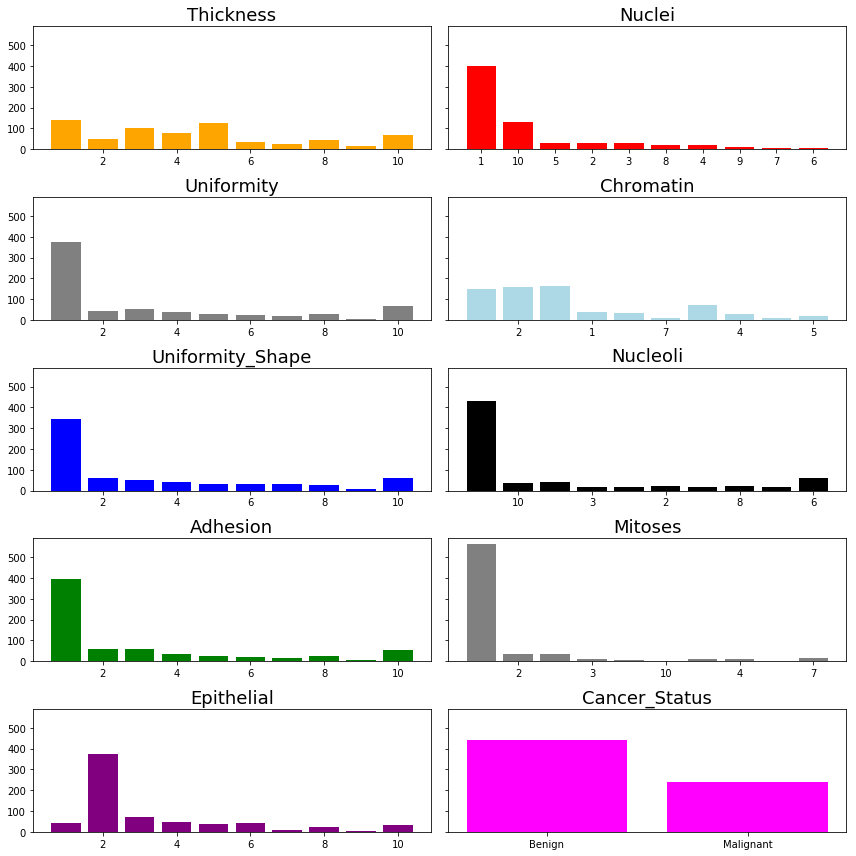

In [7]:
# Plot the value counts for each column
fig0, ax0 = plt.subplots(5,2, figsize = (12,12), sharey = True)

# First column
for i in range(0,5):
    col_num = i
    # Get values for that column
    vals = list(df.iloc[:,col_num].value_counts().index)
    counts = list(df.iloc[:,col_num].value_counts())
    name = df.iloc[:,col_num].value_counts().name[0]
    
    # Set the axes
    colors = ['orange', 'gray', 'blue', 'green', 'purple']
    ax0[i,0].bar(vals, counts, color = colors[i])
    ax0[i,0].set_title(name.title(), fontsize = 18)

# Second column
for i in range(5,10):
    col_num = i
    # Get values for that column
    vals = list(df.iloc[:,col_num].value_counts().index)
    # for cancer_status only
    if i == 9: 
        vals = ['Benign', 'Malignant']
    counts = list(df.iloc[:,col_num].value_counts())
    name = df.iloc[:,col_num].value_counts().name[0]
    
    # Set the axes
    colors = ['red', 'lightblue', 'black', 'gray', 'magenta']
    ax0[i-5,1].bar(vals, counts, color = colors[i-5])
    ax0[i-5,1].set_title(name.title(), fontsize = 18)
    ax0[i-5,1].set_xticklabels(vals)

plt.tight_layout()
plt.show()

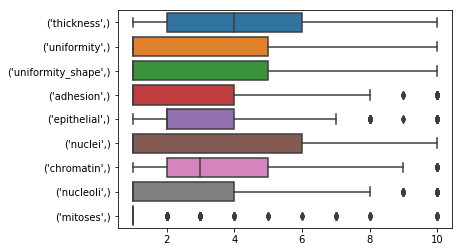

In [10]:
# Show BoxPlots
sns.boxplot(data=df.iloc[:,0:9] ,orient="h" )
plt.show()

**Summary**

Most variables exhibit severe right skewness, in particular “mitoses” (most likely referring to rate of mitosis, also known in Wolberg and Mangasarian (1990) as infrequent mitosis. Corroborated in the correlation heatmap below, uniformity and uniformity_shape (referring to the uniformity of cells and the uniformity of cell shapes) looks essentially identical in distribution.

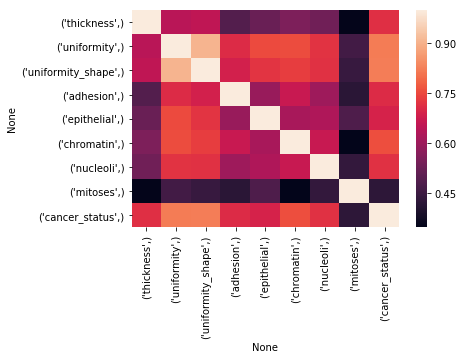

In [8]:
# Correlation matrix
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

**Key Points of Correlation Matrix:**
- Two features, uniformity shape and uniformity were correlated with other features.
- Uniformity_shape and uniformity were highly correlated with each other (r=0.91).
- Uniformity was also highly correlated with:  adhesion (r=0.71), epithelial (r=0.75), chromatin (r=0.76), and nucleoili (r=0.72).
- Uniformity_shape was also highly correlated with: adhesion (r=0.70), epithelial (r=0.72), chromatin (r=0.73)


High collinearity suggests that either regression would not be a good idea with the predictor variable set as-is (one of the variables may need to be eliminated if we are forced to use a regression model), or that model selection should focus on an algorithm for which collinearity is a minimal concern 

For this pass of our analysis we decided to use the predictor variables as is to assess the utility of including them all. Future iterations will investigate feature importance and the value of feature pruning.

# 3. Modeling with SVM (RBF Kernel)

Support Vector Machine classifiers are relatively immune to issues with collinearity. In addition, the RBF (radial basis function) kernel was able to achieve the best performance on Recall, achieving 100% for both the training and test sets.

In [12]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['cancer_status'], axis = 1),
                                                    df['cancer_status'], test_size = 0.20, random_state=42,
                                                    stratify=df['cancer_status'])

/home/natalie/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
#support vector machines model to see if we can predict cancer or no cancer
from sklearn import svm
svm_model = svm.SVC(kernel='rbf') #gamma is
svm_model.fit(X_train, y_train.values.ravel()) 

#score
svm_model.score(X_train, y_train)

#get predictions from SVM
y_predtrain = svm_model.predict(X_train)
y_predSVM = svm_model.predict(X_test) 
#pring confusion matrix for SVM
from sklearn.metrics import classification_report, confusion_matrix  

#  0  1 #predicted
#0[    ]
#1[    ]
#actual
print(confusion_matrix(y_train,y_predtrain)) 
print(classification_report(y_train, y_predtrain))

print(confusion_matrix(y_test,y_predSVM)) 
print(classification_report(y_test,y_predSVM))  

[[354   1]
 [  0 191]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       355
          1       0.99      1.00      1.00       191

avg / total       1.00      1.00      1.00       546

[[85  4]
 [ 0 48]]
             precision    recall  f1-score   support

          0       1.00      0.96      0.98        89
          1       0.92      1.00      0.96        48

avg / total       0.97      0.97      0.97       137



## Why is this model good, how can we use it?

Doctors, or patients who have their features known, can predict weather or not their biopsy will likely be cancerous. This may allow them to prioriritize patients likely to have cancer for earlier appointments so they can start treatment sooner. Especially if key metrics come back and show that cancer may be likely, like highly un-uniform cell shape and/or size.

## What insights can we draw from this analysis?

Uniformity of cell size and shape really matter, the less uniform the cells are, the more likely you are to have a cancerous biopsy. Therefore, this should be the 1st metric checked during diagnostic testing, and if results show  high uniformity additional tests should be run. If results are fairly uniform, more tests can be  issued but it is likely not as critical or time sensitive. Nucleoili higher value indicates a greater chance for cancer.

# Appendix

### Modeling with Logistic Regression

The features have various degrees of uniqueness and information contained as evidenced by their plotted distributions and correlations with other features. 

For a first pass, we elected to use a Logistic Regression for the Classification problem due to it's lightweight nature and ability to handle the collinear features with ease. Regularization will be introducted to mitigate overfitting and variance. 

We are optimizing the model for maximum Recall due to the severe downsides of missing a malignant tumor diagnosis.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [38]:
# Run a Logistic Regression with a set of regularization constants.

C_params = [0.001, 0.01, 0.1, 1, 10, 100]
for C_param in C_params:
    # Fit the model
    clf = LogisticRegression(random_state=42, penalty = 'l2', C = C_param).fit(X_train, 
                                                                               np.asarray(y_train).reshape(len(y_train,)))
    preds_train = clf.predict(X_train)
    preds_test = clf.predict(X_test)
    
    print('Results for C = {p}\n'.format(p = C_param))
    
    print('Coefficients:')
    print(list(clf.coef_))
    print('\n')
    
    # Confusion matrix for training set
    cm_train = confusion_matrix(y_train, preds_train)
    cm_train = pd.DataFrame(cm_train)
    cm_train.columns = ['Negative', 'Positive']
    cm_train.index = cm_train.columns
    print("Confusion Matrix (Train):")
    print(cm_train)
    print('\n')
    
    # Confusion matrix for test set
    cm_test = confusion_matrix(y_test, preds_test)
    cm_test = pd.DataFrame(cm_test)
    cm_test.columns = ['Negative', 'Positive']
    cm_test.index = cm_test.columns
    print("Confusion Matrix (Test):")
    print(cm_test)
    print('\n')
    
    # Output metrics for train set
    prfs_train = precision_recall_fscore_support(y_train, preds_train)
    prfs_train = np.array([prfs_train[0], prfs_train[1], prfs_train[2], prfs_train[3]])
    prfs_train = pd.DataFrame(prfs_train)
    prfs_train.columns = ['Negative', 'Positive']
    prfs_train.index = ['Precision','Recall','F-score','Support']
    print("Precision, Recall, F-Score (Train):")
    print(prfs_train)
    print('\n')
    
    # Output metrics for test set
    prfs_test = precision_recall_fscore_support(y_test, preds_test)
    prfs_test = np.array([prfs_test[0], prfs_test[1], prfs_test[2], prfs_test[3]])
    prfs_test = pd.DataFrame(prfs_test)
    prfs_test.columns = ['Negative', 'Positive']
    prfs_test.index = ['Precision','Recall','F-score','Support']
    print("Precision, Recall, F-Score (Test):")
    print(prfs_test)
    print('\n')
    
    
    # Model accuracy
    acc_train = np.trace(np.asarray(cm_train))/len(X_train)
    acc_test = np.trace(np.asarray(cm_test))/len(X_test)
    print('Train Accuracy is {a:0.2f}%'.format(a = acc_train*100))
    print('Test Accuracy is {a:0.2f}%'.format(a = acc_test*100))
    print('\n')
    
    print('--------------------------------------------')
    print('\n')
    
    

Results for C = 0.001

Coefficients:
[array([-0.07765896,  0.09010444,  0.07544834,  0.03272061, -0.07595733,
        0.12421498, -0.05784205,  0.05657193, -0.03773257])]


Confusion Matrix (Train):
          Negative  Positive
Negative       298        57
Positive        12       179


Confusion Matrix (Test):
          Negative  Positive
Negative        73        16
Positive         1        47


Precision, Recall, F-Score (Train):
             Negative    Positive
Precision    0.961290    0.758475
Recall       0.839437    0.937173
F-score      0.896241    0.838407
Support    355.000000  191.000000


Precision, Recall, F-Score (Test):
            Negative   Positive
Precision   0.986486   0.746032
Recall      0.820225   0.979167
F-score     0.895706   0.846847
Support    89.000000  48.000000


Train Accuracy is 87.36%
Test Accuracy is 87.59%


--------------------------------------------


Results for C = 0.01

Coefficients:
[array([-0.15507101,  0.30433147,  0.19154066,  0.07020102,

**Summary of Logistic Regression:**

An L2 regularization with C = 100 optimized the Recall of the model at 97.9 for the test set and 95.8 for the training set. Further increases in C had a negligible affect on these results. 

The thickness, nuclei, and mitoses have the largest coefficients. 

## Modeling with Random Forest

We also tried to fit the data with a Random Forest classifier. Though it is relatively easy to specify and run, Random Forest classifiers frequently run into issues with overfitting. We specified hyperparameters with a forest size of 1000 (significantly more than the scikit-learn default setting of 100) and a maximum tree depth of 5.
Model performance was relatively good overall, with very rare false negative misclassifications. Recall rate for the training set was 98.6%, while recall rate for the test set was 95.5%.


Gradient Boosting Algorithm is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. 

The advantages of GBRT are:
- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:
- Scalability, due to the sequential nature of boosting it can hardly be parallelized.


In [44]:
# Gradient Boosting
from sklearn import ensemble
from sklearn.model_selection import cross_val_predict

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 
                   'random_state': 2, 'min_samples_split': 5}

params = dict(original_params)
#params.update(setting)

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
        
y_train_pred=cross_val_predict(clf, X_train,y_train,cv=5)

confusion_matrix(y_train,y_train_pred)



/home/spwhite1337/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/spwhite1337/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/spwhite1337/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/spwhite1337/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

array([[347,   8],
       [  9, 182]])

precision=0.9538461538461539


recall=0.9738219895287958
